# PCA On Fire Images

## Introduction

PCA is mostly known as a dimensionality reduction technique that aims in preserving most of the variance of the features. In addition, our new feature space is **uncorellated**.  
  
In our case we will use PCA in an attempt to **reduce noise on fire images**.  

* **Why fire images?**  
Normally the suggested flow would be to get the [MNIST digits dataset](http://yann.lecun.com/exdb/mnist/) apply some random noise, apply denoising using PCA and explore the visual results. However, this [already exists](https://stats.stackexchange.com/a/247271). Also, a friend of mine (who generously gave me access to his dataset) is writing his thesis on fire recognition on images, so we could test or results. 

Steps for applying PCA for denoising an image dataset:
1. Let $X$ be our datapoints of shape $nxm$ where $n$ features (number of pixels), $m$ datapoints
2. Centralize $X$ by $M_X$ (mean of $X$) to get centralized $\bar{X}=X
- M_X$
3. Calculate $C_\bar{X} = \bar{X}\bar{X^T}$ (Covariance of $\bar{X}$ since X is centralized) 
4. Let $U_p$ the first $p$ eigenvectors of  $C_\bar{X}$ ($p$ is decided by us to cover as much variance as we want)
5. Encode the training data $Y=U_p^T\bar{X}$ (dimensionality reduction)
6. Return to the starting dimensions $\hat{X}=U_pY$
7. Recenter our datapoints $X_{final}=\hat{X} + M_X$

**Note: On the code below I use the [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), which performs some of the above steps implicitly**


In [33]:
import os
import random 

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

## Reading the images

The first thing we are going to do is get the images and resize them in order to have matching dimensions.

After reading and resizing we end up with a list of dictionaries where each dictionary is:
```python
{
    'path': str of image filename
    'img': ndarray of the RGB image
}
```

In [18]:
# Widths and height of the new dataset (care that we do not keep the aspect ratio of the images)
width = 128
height = 128
dim = (width, height)

images_list = []

images_dir = os.listdir('datasets/fire-smoke/') # Get all the images file names
for img_path in tqdm(images_dir, desc='Reading and Resizing'):
    img = cv2.imread('datasets/fire-smoke/' + img_path, cv2.IMREAD_UNCHANGED)
    images_list.append({
                        'path': img_path,
                        'img': cv2.resize(img, dim, interpolation = cv2.INTER_AREA) #ndarray of shape [width, height , 3]
                        })                                                          # The images are RGB which explains the 3rd dimension

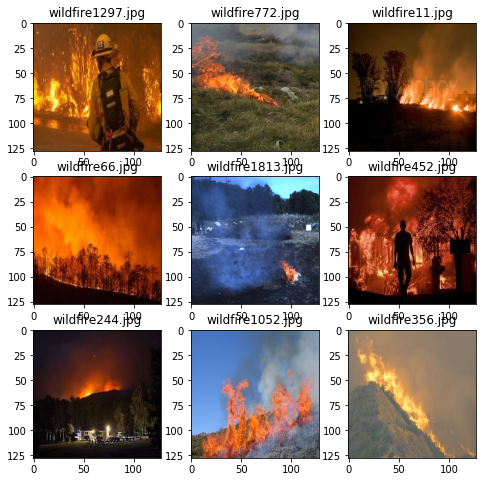

In [32]:
# Show 9 random images
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img_index = random.randrange(len(images_list))
    plt.imshow(cv2.cvtColor(imbages_list[img_index]['img'], cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title(images_list[img_index]['path'])
plt.show()

In [66]:
print(images_list[0]['img'].shape)

(128, 128, 3)


I should note that our images have 3 channels. This means that we must decide if we are going to apply PCA independently on each channel or stack them together and perform one PCA.  

Firstly, I will do the 3 independent PCAs and I expect to not be difficult to transition to applying one PCA on all the channels

## Independent PCAs on each channel


In [43]:
# Create our 3 ndarrays for each channel
channels_numb = 3
channel_array = []
for which_channel in range(channels_numb):
    temp_channel = []
    for which_img in images_list:
        temp_channel.append(which_img['img'][:, :, which_channel])
    channel_array.append(temp_channel)
    
channel_array = np.array(channel_array) # ndarray of shape #channels(3), #images(560), width, height

# We reshape so as to flatten width and height dimensions
channel_array = np.reshape(channel_array, (channels_numb, len(images_list), width * height))

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [82]:
pca_projections = []
for which_channel in range(channels_numb):
    temp_pca = PCA(n_components=100)    # Initialize PCA
    temp_pca.fit(channel_array[which_channel])    # Fit on our channel
    X_transformed = temp_pca.transform(channel_array[which_channel])    # Transform our channel
    X_orig = temp_pca.inverse_transform(X_transformed)    # Inverse transform to return to our original feature space
    X_orig_reshape = np.reshape(X_orig, (560, width, height))    # Reshape so as to match the starting width and heights
    pca_projections.append(X_orig_reshape)

pca_projections = np.array(pca_projections)
pca_projections = np.moveaxis(pca_projections, [0, 1], [3, 0])
print(pca_projections.shape)    # Final shape of our images dataset

(560, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


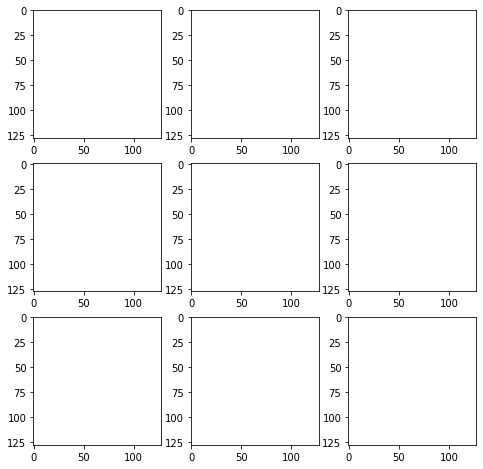

In [84]:
# Show 9 random images
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img_index = random.randrange(len(pca_projections))
    plt.imshow(pca_projections[img_index])    # Failing to plot the channels together, could try to "manually" multiply eigenvectors with X
plt.show()